# <center>Using SQLite for a data warehouse</center>

### Author:  Bryan Cafferky  - For Demonstration Purposes Only

### Not intended for production use. 

## Documentation at: https://docs.python.org/3/library/sqlite3.html

### Note:  Required libraries will be imported at the top of each cell
###        redundantly so each cell can execute independently.

### Quirks of SQLite

* Data Types Are Not Enforced.
* No Right or Full Outer Joins.
* Alter Table is very limited.
* Tables default to having a unique integer rowid column.
* SQLite is a library not a service.
* In-Memory Database Feature.

### SQLite Advanced Database Features...

* Views and temporary tables are supported.
* Foreign Key Constraints (Referential Integrity)
* Primary Key and Unique Constraints
* Not Null Constraint
* Default Values including Date and TimeStamp
* Triggers
* Calculated Columns - called generated columns (fairly new January 2020)
* Automatic SQL Data Type Mapping from popular DBMS products

# Create or Point to Our SQLite database...

### 1)  Load the SQLite package...

In [1]:
import sqlite3

print(sqlite3.sqlite_version)

3.50.1


In [4]:
# !pip install pandasql/

In [5]:
from pandasql import sqldf

def pysqldf(q):
    """this function eliminates the need to include locals/globals all the time"""
    return sqldf(q, globals())

### 2) Connect to the database.  

In [6]:
conn = sqlite3.connect('aw_dw.db') # permanent database

In [7]:
print(conn)

### 3)  Create a cursor to execute statements to SQLite.

In [8]:
cursor = conn.cursor()

In [9]:
cursor

# Our Strategy to Build the Warehouse.

- Use pandas dataframes as the source of data to be loaded into warehouse.
- Use SQLDF() to query and extract data from the source dataframes.
- Note: SQLDF() allows you to query dataframes with SQL but there are no tables!!!
- Use the Python SQLite3 library to create the warehouse tables and insert data.

# Get Data from database management systems...

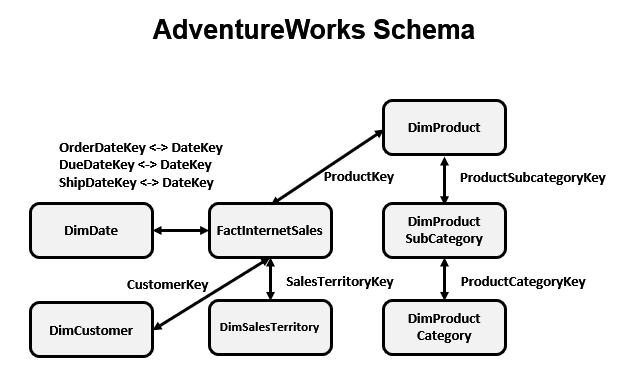

### Our data is in CSV files.

#### Read in the CSV files...

In [10]:
import pandas as pd

dfdate = pd.read_csv('./data/DimDate.csv')
dfdate = dfdate[dfdate['DateKey'] > 20111231]

In [11]:
dfdate.head(2)

,DateKey,FullDateAlternateKey,DayNumberOfWeek,EnglishDayNameOfWeek,SpanishDayNameOfWeek,FrenchDayNameOfWeek,DayNumberOfMonth,DayNumberOfYear,WeekNumberOfYear,EnglishMonthName,SpanishMonthName,FrenchMonthName,MonthNumberOfYear,CalendarQuarter,CalendarYear,CalendarSemester,FiscalQuarter,FiscalYear,FiscalSemester
2556,20120101,2012-01-01,1,Sunday,Domingo,Dimanche,1,1,1,January,Enero,Janvier,1,1,2012,1,3,2011,2
2557,20120102,2012-01-02,2,Monday,Lunes,Lundi,2,2,1,January,Enero,Janvier,1,1,2012,1,3,2011,2


### We can use sqldf to query the dataframe with SQL.

In [12]:
pysqldf('''select * from dfdate limit 3''')

,DateKey,FullDateAlternateKey,DayNumberOfWeek,EnglishDayNameOfWeek,SpanishDayNameOfWeek,FrenchDayNameOfWeek,DayNumberOfMonth,DayNumberOfYear,WeekNumberOfYear,EnglishMonthName,SpanishMonthName,FrenchMonthName,MonthNumberOfYear,CalendarQuarter,CalendarYear,CalendarSemester,FiscalQuarter,FiscalYear,FiscalSemester
0,20120101,2012-01-01,1,Sunday,Domingo,Dimanche,1,1,1,January,Enero,Janvier,1,1,2012,1,3,2011,2
1,20120102,2012-01-02,2,Monday,Lunes,Lundi,2,2,1,January,Enero,Janvier,1,1,2012,1,3,2011,2
2,20120103,2012-01-03,3,Tuesday,Martes,Mardi,3,3,1,January,Enero,Janvier,1,1,2012,1,3,2011,2


### To execute more than one statement, use the executescript() method.

In [13]:
create_dimdate = '''
DROP TABLE IF EXISTS dimdate;

CREATE TABLE dimdate (
    DateKey                INTEGER NOT NULL PRIMARY KEY,
    DateValue              DATE    NOT NULL,
    DayNumberOfWeek        INTEGER NOT NULL,
    DayNameOfWeek          TEXT    NOT NULL,
    DayNumberOfMonth       INTEGER NOT NULL,
    DayNumberOfYear        INTEGER NOT NULL,
    WeekNumberOfYear       INTEGER NOT NULL,
    MonthName              TEXT NOT NULL,
    MonthNumberOfYear      INTEGER NOT NULL,
    CalendarQuarter        INTEGER NOT NULL,
    CalendarYear           INTEGER NOT NULL,
    FiscalQuarter          INTEGER NOT NULL,
    FiscalYear             INTEGER NOT NULL 
);
''' 

In [14]:
cursor.executescript(create_dimdate)

### Use sqldf() to pull just the data you want from the dataframe 
### and append .to_sql() to write the results to your SQLite database.

In [15]:
pysqldf(''' 
select  DateKey           
       ,FullDateAlternateKey as DateValue         
       ,DayNumberOfWeek   
       ,EnglishDayNameOfWeek as DayNameOfWeek     
       ,DayNumberOfMonth   
       ,DayNumberOfYear   
       ,WeekNumberOfYear  
       ,EnglishMonthName as MonthName         
       ,MonthNumberOfYear 
       ,CalendarQuarter   
       ,CalendarYear      
       ,FiscalQuarter     
       ,FiscalYear   
from dfdate;
''').to_sql('dimdate', 
             con=conn, index=False, 
             if_exists='append')

1096

### SalesTerritory

In [16]:
import pandas as pd

dfsalesterritory = pd.read_csv('./data/DimSalesTerritory.csv')

In [18]:
pysqldf("""select * from dfsalesterritory""").head(3)

,SalesTerritoryKey,SalesTerritoryAlternateKey,SalesTerritoryRegion,SalesTerritoryCountry,SalesTerritoryGroup,SalesTerritoryImage
0,1,1,Northwest,United States,North America,0xFFD8FFE000104A46494600010101004800480000FFDB...
1,2,2,Northeast,United States,North America,0xFFD8FFE000104A46494600010101004800480000FFDB...
2,3,3,Central,United States,North America,0xFFD8FFE000104A46494600010101004800480000FFDB...


### Let pandas create the table for us.

In [19]:
pysqldf('''select SalesTerritoryKey, 
         SalesTerritoryRegion, 
         SalesTerritoryCountry, 
         SalesTerritoryGroup from dfsalesterritory;''').to_sql('dimsalesterritory', 
                                                               con=conn, index=False, 
                                                               if_exists='replace')

11

### Create a unique index on the table.

In [20]:
cursor.executescript('''
BEGIN TRANSACTION;
create unique index if not exists idx_salesterritorykey on dimsalesterritory (SalesTerritoryKey);  
commit;
 ''')

In [22]:
import pandas as pd

dfgeography = pd.read_csv('./data/DimGeography.csv')
dfgeography.dtypes

GeographyKey                 int64
City                        object
StateProvinceCode           object
StateProvinceName           object
CountryRegionCode           object
EnglishCountryRegionName    object
SpanishCountryRegionName    object
FrenchCountryRegionName     object
PostalCode                  object
SalesTerritoryKey            int64
IpAddressLocator            object
dtype: object

In [23]:
dfgeography.head(3)

,GeographyKey,City,StateProvinceCode,StateProvinceName,CountryRegionCode,EnglishCountryRegionName,SpanishCountryRegionName,FrenchCountryRegionName,PostalCode,SalesTerritoryKey,IpAddressLocator
0,1,Alexandria,NSW,New South Wales,AU,Australia,Australia,Australie,2015,9,198.51.100.2
1,2,Coffs Harbour,NSW,New South Wales,AU,Australia,Australia,Australie,2450,9,198.51.100.3
2,3,Darlinghurst,NSW,New South Wales,AU,Australia,Australia,Australie,2010,9,198.51.100.4


In [24]:
create_dimgeography = '''
DROP TABLE IF EXISTS dimgeography;

CREATE TABLE IF NOT EXISTS dimgeography (
    GeographyKey                INTEGER PRIMARY KEY,
    City                        TEXT,
    StateProvinceCode           TEXT,
    StateProvinceName           TEXT,
    CountryRegionCode           TEXT,
    CountryRegionName           TEXT,
    PostalCode                  TEXT,
    SalesTerritoryKey           INTEGER NOT NULL,  
    InsertDate                  TIMESTAMP NOT NULL DEFAULT CURRENT_TIMESTAMP,
    FOREIGN KEY (SalesTerritoryKey)
       REFERENCES dimsalesterritory (SalesTerritoryKey) 
);
'''

In [25]:
cursor.executescript(create_dimgeography)

In [27]:
dfgeographysubset = pysqldf('''
select  GeographyKey,
        City,                        
        StateProvinceCode,           
        StateProvinceName,           
        CountryRegionCode,           
        EnglishCountryRegionName as CountryRegionName,           
        PostalCode,                  
        SalesTerritoryKey  
from dfgeography
''')

In [28]:
dfgeographysubset.head(2)

,GeographyKey,City,StateProvinceCode,StateProvinceName,CountryRegionCode,CountryRegionName,PostalCode,SalesTerritoryKey
0,1,Alexandria,NSW,New South Wales,AU,Australia,2015,9
1,2,Coffs Harbour,NSW,New South Wales,AU,Australia,2450,9


In [29]:
# Store the results in our SQLite data warehouse

# if_exists options are replace, append, and fail, 
dfgeographysubset.to_sql('dimgeography', con=conn, index=False, if_exists='append')

655

In [30]:
import pandas as pd

dfproduct = pd.read_csv('./data/DimProduct.csv')
dfproduct.head(1)

,ProductKey,ProductAlternateKey,ProductSubcategoryKey,WeightUnitMeasureCode,SizeUnitMeasureCode,EnglishProductName,SpanishProductName,FrenchProductName,StandardCost,FinishedGoodsFlag,...,ChineseDescription,ArabicDescription,HebrewDescription,ThaiDescription,GermanDescription,JapaneseDescription,TurkishDescription,StartDate,EndDate,Status
0,1,AR-5381,NaN,NaN,NaN,Adjustable Race,NaN,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2003-07-01 00:00:00.000,NaN,Current


In [31]:
import pandas as pd

dfproductsubcategory = pd.read_csv('./data/DimProductSubCategory.csv')
dfproductsubcategory.head(1)

,ProductSubcategoryKey,ProductSubcategoryAlternateKey,EnglishProductSubcategoryName,SpanishProductSubcategoryName,FrenchProductSubcategoryName,ProductCategoryKey
0,1,1,Mountain Bikes,Bicicleta de montaña,VTT,1


In [32]:
import pandas as pd

dfproductcategory = pd.read_csv('./data/DimProductCategory.csv')
dfproductcategory.head(1)

,ProductCategoryKey,ProductCategoryAlternateKey,EnglishProductCategoryName,SpanishProductCategoryName,FrenchProductCategoryName
0,1,1,Bikes,Bicicleta,Vélo


#### We use an inner join even though a product could have a null ProductSubcategoryKey.

In [34]:
sql = '''
SELECT ProductKey,
       EnglishProductCategoryName as Category,
       sc.EnglishProductSubcategoryName as SubCategory,
       p.EnglishProductName as Product,
       p.ModelName as Model,
       ifnull(round(p.ListPrice,2), 0) as ListPrice
FROM dfproduct                       p
INNER JOIN dfproductsubcategory      sc
  ON (p.ProductSubcategoryKey = sc.ProductSubcategoryKey)
INNER JOIN dfproductcategory         pc
  ON (sc.ProductCategoryKey = pc.ProductCategoryKey)
'''

In [35]:
pysqldf(sql).head(3)

,ProductKey,Category,SubCategory,Product,Model,ListPrice
0,210,Components,Road Frames,"HL Road Frame - Black, 58",HL Road Frame,0.00
1,211,Components,Road Frames,"HL Road Frame - Red, 58",HL Road Frame,0.00
2,212,Accessories,Helmets,"Sport-100 Helmet, Red",Sport-100,33.64


In [36]:
dfproductsubset = pysqldf(sql)

In [37]:
cursor.execute('drop table if exists dimproduct')

In [38]:
create_dimproduct = '''
CREATE TABLE IF NOT EXISTS dimproduct (
    ProductKey          INTEGER PRIMARY KEY,
    Category            TEXT,
    SubCategory         TEXT,
    Product             TEXT,
    Model               TEXT,
    ListPrice           FLOAT,
    [InsertDate]        TIMESTAMP NOT NULL DEFAULT CURRENT_TIMESTAMP
);
'''

In [39]:
cursor.execute(create_dimproduct)

In [40]:
# Store the results in our SQLite data warehouse

# if_exists options are replace, append, 
dfproductsubset.to_sql('dimproduct', con=conn, index=False, if_exists='append')

397

#### Getting meta data...

In [41]:
dfproductsubset.columns 

Index(['ProductKey', 'Category', 'SubCategory', 'Product', 'Model',
       'ListPrice'],
      dtype='object')

In [42]:
import sqlite3
import pandas as pd

# convert query results to a dataframe
pd.read_sql_query("SELECT * FROM sqlite_master where name = 'dimproduct'", conn)

,type,name,tbl_name,rootpage,sql
0,table,dimproduct,dimproduct,33,CREATE TABLE dimproduct (\n ProductKey ...


In [43]:
# Get table schema...
import pandas as pd 

pd.read_sql_query("""
PRAGMA table_info('dimproduct');
""", conn)

,cid,name,type,notnull,dflt_value,pk
0,0,ProductKey,INTEGER,0,None,1
1,1,Category,TEXT,0,None,0
2,2,SubCategory,TEXT,0,None,0
3,3,Product,TEXT,0,None,0
4,4,Model,TEXT,0,None,0
5,5,ListPrice,FLOAT,0,None,0
6,6,InsertDate,TIMESTAMP,1,CURRENT_TIMESTAMP,0


In [44]:
import sqlite3
import pandas as pd

pd.read_sql_query("SELECT * FROM dimproduct limit 3", conn)

,ProductKey,Category,SubCategory,Product,Model,ListPrice,InsertDate
0,210,Components,Road Frames,"HL Road Frame - Black, 58",HL Road Frame,0.00,2025-08-26 10:52:32
1,211,Components,Road Frames,"HL Road Frame - Red, 58",HL Road Frame,0.00,2025-08-26 10:52:32
2,212,Accessories,Helmets,"Sport-100 Helmet, Red",Sport-100,33.64,2025-08-26 10:52:32


## Taking complete control in defining and loading your table...
- Defining a custom autoincremented primary key.
- Created calculated columns.
- Creating foreign keys and using referential integrity.
- Defining default values.
- Creating check constraints.
- Loading data in chunks.

### Autoincrement

1. The AUTOINCREMENT keyword imposes extra CPU, memory, disk space, and disk I/O overhead and should be avoided if not strictly needed. It is usually not needed.

2. In SQLite, a column with type INTEGER PRIMARY KEY is an alias for the ROWID (except in WITHOUT ROWID tables) which is always a 64-bit signed integer.

3. On an INSERT, if the ROWID or INTEGER PRIMARY KEY column is not explicitly given a value, then it will be filled automatically with an unused integer, usually one more than the largest ROWID currently in use. This is true regardless of whether or not the AUTOINCREMENT keyword is used.

4. If the AUTOINCREMENT keyword appears after INTEGER PRIMARY KEY, that changes the automatic ROWID assignment algorithm to prevent the reuse of ROWIDs over the lifetime of the database. In other words, the purpose of AUTOINCREMENT is to prevent the reuse of ROWIDs from previously deleted rows.

### Calculated Columns

* The expression of a generated column may only reference constant literals and columns within the same row, and may only use scalar deterministic functions. The expression may not use subqueries, aggregate functions, window functions, or table-valued functions.

* The expression of a generated column may refer to other generated columns in the same row, but no generated column can depend upon itself, either directly or indirectly.

## Create the table...

### Do Not Use AutoIncrement Keyword (Unless you research it first)
https://sqlite.org/autoinc.html

In [45]:
#      [ProfitMargin]  [real] GENERATED ALWAYS AS ( (SalesAmount - TotalProductCost ) / SalesAmount ) STORED 

create_factinternetsales = '''

DROP TABLE IF EXISTS factinternetsales;

CREATE TABLE [factinternetsales](
    [ID]                     INTEGER    NOT NULL PRIMARY KEY,
    [ProductKey]             [int]      NOT NULL ,
    [OrderDateKey]           [int]      NOT NULL,
    [DueDateKey]             [int]      NOT NULL,
    [ShipDateKey]            [int]      NOT NULL,
    [CustomerKey]            [int]      NOT NULL,
    [PromotionKey]           [int]      NOT NULL,
    [CurrencyKey]            [int]      NOT NULL,
    [SalesTerritoryKey]      [int]      NOT NULL,
    [OrderQuantity]          [smallint] NOT NULL,
    [UnitPrice]              [money]    NOT NULL,
    [UnitPriceDiscountPct]   [float]    NOT NULL,
    [DiscountAmount]         [float]    NOT NULL,
    [ProductStandardCost]    [money]    NOT NULL,
    [TotalProductCost]       [money]    NOT NULL,
    [SalesAmount]            [money]    NOT NULL  CHECK (SalesAmount >= 0 ),
    [TaxAmt]                 [money]    NOT NULL,
    [Freight]                [money]    NOT NULL,
    [OrderDate]              [datetime] NULL,
    [DueDate]                [datetime] NULL,
    [ShipDate]               [datetime] NULL,
    [TaxRate]                [real]     NULL  DEFAULT 0, 
    [ProfitMargin]           [real]     NULL,
    [InsertDate]             TIMESTAMP NOT NULL DEFAULT CURRENT_TIMESTAMP,
    FOREIGN KEY(ProductKey)        REFERENCES dimproduct(ProductKey),
    FOREIGN KEY(SalesTerritoryKey) REFERENCES dimsalesterritory(SalesTerritoryKey)
);
'''

### Use executescript() because the SQL includes multiple statements.

In [49]:
cursor.executescript(create_factinternetsales)

##### What if we have a CSV file that won't all fit into memory?  
##### Imagine FactInternetSales.csv is too big to fit into a dataframe, i.e. into memory.
##### It has over 60,000 rows so may actually be true on some machines.

In [50]:
import pandas as pd

dffactinternetsales = pd.read_csv('./data/FactInternetSales2014.csv')
dffactinternetsales.shape

(1970, 26)

#### First define your SQL query that defines the columns you will load.

In [51]:
sql_factinternetsales = '''
SELECT 
       ProductKey,
       OrderDateKey,
       DueDateKey,
       ShipDateKey,
       CustomerKey,
       PromotionKey,
       CurrencyKey,
       SalesTerritoryKey,
       OrderQuantity,
       UnitPrice,
       UnitPriceDiscountPct,
       DiscountAmount,
       ProductStandardCost,
       TotalProductCost,
       SalesAmount,
       TaxAmt,
       Freight,
       OrderDate,
       DueDate,
       ShipDate,
       round((TaxAmt/SalesAmount),2) as TaxRate,
       round(((SalesAmount - TotalProductCost ) / SalesAmount), 2) as ProfitMargin
  FROM dffactinternetsales  
'''

### Let's test the load query...

In [52]:
pysqldf(sql_factinternetsales).head(2)

,ProductKey,OrderDateKey,DueDateKey,ShipDateKey,CustomerKey,PromotionKey,CurrencyKey,SalesTerritoryKey,OrderQuantity,UnitPrice,...,ProductStandardCost,TotalProductCost,SalesAmount,TaxAmt,Freight,OrderDate,DueDate,ShipDate,TaxRate,ProfitMargin
0,535,20140101,20140113,20140108,11051,1,100,9,1,24.99,...,9.3463,9.3463,24.99,1.9992,0.6248,00:00.0,00:00.0,00:00.0,0.08,0.63
1,528,20140101,20140113,20140108,11051,1,100,9,1,4.99,...,1.8663,1.8663,4.99,0.3992,0.1248,00:00.0,00:00.0,00:00.0,0.08,0.63


### Load the factinternetsales table

In [53]:
import pandas as pd

pysqldf(sql_factinternetsales).to_sql('factinternetsales', con=conn, index=False, if_exists='append')

1970

# ***** Create DW Stops Here ****

### Querying data in SQLite...

In [54]:
import sqlite3
import pandas as pd

pd.read_sql_query('''
select Category, SubCategory, Product, round(sum(SalesAmount),2) as SalesAmount  
FROM        factinternetsales s
inner join  dimproduct        p
on (s.ProductKey = p.ProductKey)
group by Category, SubCategory, Product 
''', conn).head(4)

,Category,SubCategory,Product,SalesAmount
0,Accessories,Bike Racks,Hitch Rack - 4-Bike,2400.00
1,Accessories,Bike Stands,All-Purpose Bike Stand,1749.00
2,Accessories,Bottles and Cages,Mountain Bottle Cage,699.30
3,Accessories,Bottles and Cages,Road Bottle Cage,80.91


### Create a SQLite view that pulls all the data together...
##### Note the 'if not exists' - so you don't get an error on reruns...

In [55]:
sql = '''
drop view if exists vsalesinfo;

CREATE VIEW IF NOT EXISTS vsalesinfo as  
SELECT  OrderDateKey, DueDateKey, SalesTerritoryKey,
SalesAmount, p.*, OrderQuantity, TotalProductCost, TaxAmt, 
d.FiscalYear, d.FiscalQuarter, d.MonthName as Month, MonthNumberOfYear, d.CalendarYear
FROM factinternetsales                s
INNER JOIN dimproduct                 p
ON (s.ProductKey = p.ProductKey)
INNER JOIN dimdate                    d
ON (s.OrderDateKey = d.DateKey);
'''

In [56]:
# We created the cursor to the SQLite database at the beginning.

cursor.executescript(sql)

In [57]:
pd.read_sql_query('select * from vsalesinfo limit 3', conn)

,OrderDateKey,DueDateKey,SalesTerritoryKey,SalesAmount,ProductKey,Category,SubCategory,Product,Model,ListPrice,InsertDate,OrderQuantity,TotalProductCost,TaxAmt,FiscalYear,FiscalQuarter,Month,MonthNumberOfYear,CalendarYear
0,20140101,20140113,9,24.99,535,Accessories,Tires and Tubes,LL Mountain Tire,LL Mountain Tire,24.99,2025-08-26 10:52:32,1,9.3463,1.9992,2013,3,January,1,2014
1,20140101,20140113,9,4.99,528,Accessories,Tires and Tubes,Mountain Tire Tube,Mountain Tire Tube,4.99,2025-08-26 10:52:32,1,1.8663,0.3992,2013,3,January,1,2014
2,20140101,20140113,9,34.99,222,Accessories,Helmets,"Sport-100 Helmet, Blue",Sport-100,34.99,2025-08-26 10:52:32,1,13.0863,2.7992,2013,3,January,1,2014


In [58]:
sql = '''
SELECT t.SalesTerritoryCountry, t.SalesTerritoryRegion, SUM(SalesAmount)
FROM  FactInternetSales   s
JOIN  DimSalesTerritory   t
ON (s.SalesTerritoryKey = t.SalesTerritoryKey)
GROUP BY SalesTerritoryCountry, SalesTerritoryRegion
ORDER BY SUM(SalesAmount) DESC
'''

In [59]:
pd.read_sql_query(sql, conn, index_col=['SalesTerritoryCountry']).round(2)

,SalesTerritoryRegion,SUM(SalesAmount)
SalesTerritoryCountry,,
Canada,Canada,9457.62
United States,Northwest,9091.81
Australia,Australia,8507.72
United States,Southwest,8376.06
United Kingdom,United Kingdom,3713.64
Germany,Germany,3277.83
France,France,3195.06
United States,Southeast,74.98


## We can drop the table since we are done.

# Let's close the connection. 

In [60]:
cursor.close()
conn.close()